This notebook replicated results from visual behavior novelty paper, figure 4 (plus some supplemental figures). 

The steps include:
loading GLM output for each cell
select cells that were imaged during days of interests (Familiar, Novel, Novel+). 
select only matched cells

Optimal number of clusters with Gap statistic

Constructing coclustering matrix with optimal k

Applying hierarchical clustering on coclustering matrix to obrain robust cluster id assignment for each neuron

Visualize clusters

Visualize clusters by cre line

Perform area and depth analysis for the clusters
visualize distribution of clusters by area and depth
perform statistical analysis across areas and depths




# Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


# import visual_behavior.data_access.loading as loading # Files should be saved in a clear location
# import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.utils as utils

experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

import seaborn as sns
import jetplot
import matplotlib.colors
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting # functions to plot clusters
from visual_behavior.dimensionality_reduction.clustering import processing # function for computing and validating clusters

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


# Load data

## GLM output

In [4]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas

In [5]:
# remove this later
# cells_table = loading.get_cell_table()
# cells_table.to_pickle(os.path.join(base_path, 'all_cells_table.pkl'))

In [6]:
# cells_table_matched = loading.get_matched_cells_table(cells_table)
# cells_table_matched.to_pickle(os.path.join(base_path, 'matched_cells_table.pkl'))

In [7]:
# base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
# save_dir = os.path.join(base_dir, 'all_cre_clustering_113023')
# folder = 'figs'

In [8]:
# path to data file
path = r'C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache'
base_path = os.path.abspath(path)

In [9]:
cells_table = pd.read_pickle(os.path.join(base_path, 'all_cells_table.pkl'))

In [10]:
cells_table_matched = pd.read_pickle(os.path.join(base_path, 'matched_cells_table.pkl'))

In [11]:
cre_lines = np.sort(cells_table_matched.cre_line.unique())
cell_types = {'Slc17a7-IRES2-Cre': 'Excitatory',
 'Sst-IRES-Cre': 'Sst Inhibitory',
 'Vip-IRES-Cre': 'Vip Inhibitory'}

In [12]:
# Define the file path
file_path = os.path.join(base_path, 'GLM', 'all_GLM_output.pkl')
glm_version = '24_events_all_L2_optimize_by_session'
# Check if the file exists
if os.path.exists(file_path):
    print("Loading existing GLM output...")
    # Load the file
    all_results_pivoted = pd.read_pickle(file_path)
    print("GLM output loaded.")
else:
    print("Creating and saving GLM output...")
    # Make the file
    run_params, all_results, all_results_pivoted, weights_df = gfd.load_analysis_dfs(glm_version)
    all_results_pivoted.to_pickle(file_path)
    print("GLM output created and saved.")

Loading existing GLM output...
GLM output loaded.


In [13]:
%%time
# Define the file path to all across session normalization
file_path = os.path.join(base_path, 'GLM', 'across_session_normalized_GLM_output.pkl')

# Check if the file exists
if os.path.exists(file_path):
    # Load the file
    across_results = pd.read_pickle(file_path)
else:
    # Create the file
    across_results, failed_cells = gas.load_cells(glm_version, clean_df=True)
    across_results = across_results.set_index('identifier')
    across_results.to_pickle(file_path)

Wall time: 34.9 ms


In [14]:
# across_results.to_hdf(os.path.join(base_path, 'GLM', 'all_GLM_output.h5'), key='df', format='table')
# ValueError: cannot interpret dtype of [Int64]

In [15]:
# load clean matched cells results for clustering
# Note that suffix '_across' was removed from regressor names, exp levels cleaned renamed
matched_glm = pd.read_pickle(os.path.join(base_path, 'GLM', 'across_session_normalized_matched_cells_GLM_output.pkl'))

In [16]:
matched_glm.head()

,all-images,omissions,task,behavioral,cell_specimen_id,experience_level
identifier,,,,,,
794381992_1086551315,0.000000,0.0,0.000000,0.0,1086551315,Familiar
795076128_1086551315,0.295018,0.0,0.094833,0.0,1086551315,Novel
796105304_1086551315,0.258126,0.0,0.430496,0.0,1086551315,Novel +
794381992_1086550804,0.000000,0.0,0.000000,0.0,1086550804,Familiar
795076128_1086550804,0.000000,0.0,0.000000,0.0,1086550804,Novel



# Clustering steps


## Feature matrix (coding scores)

In [17]:
glm_path = os.path.join(base_path, 'GLM')

In [18]:
#Define the file paths
feature_matrix_path = os.path.join(glm_path, 'feature_matrix.pkl')
if not os.path.exists(feature_matrix_path):
    print("Creating feature matrix...")
    # Make the feature matrix file
    feature_matrix = processing.get_feature_matrix_for_clustering(matched_glm, glm_version, save_dir=glm_path)
    feature_matrix.to_pickle(feature_matrix_path)
    print("Feature matrix created and saved.")
else:
    print("Loading feature matrix...")
    # Load the feature matrix file
    feature_matrix = pd.read_pickle(feature_matrix_path)
    print("Feature matrix loaded.")


Loading feature matrix...
Feature matrix loaded.


In [19]:
cell_metadata_path = os.path.join(glm_path, 'cell_metadata.pkl')
if not os.path.exists(cell_metadata_path):
    print("Creating cell metadata...")
    # Make the cell metadata file
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table_matched)
    cell_metadata.to_pickle(cell_metadata_path)
    print("Cell metadata created and saved.")
else:
    print("Loading cell metadata...")
    # Load the cell metadata file
    cell_metadata = pd.read_pickle(cell_metadata_path)
    print("Cell metadata loaded.")

Loading cell metadata...
Cell metadata loaded.


## Optimal number of clusters

### gap statistic

In [20]:

metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(glm_path, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_df = pickle.load(f)
        print('loaded file')
else:
    
    sc = SpectralClustering()
    gap_df = processing.compute_gap(clustering=sc, data=feature_matrix, k_max = k_max, 
                                    reference_shuffle=shuffle_type, metric=metric, separate_cre_lines=True)
    processing.save_clustering_results(gap_df, gap_filename)

loaded file


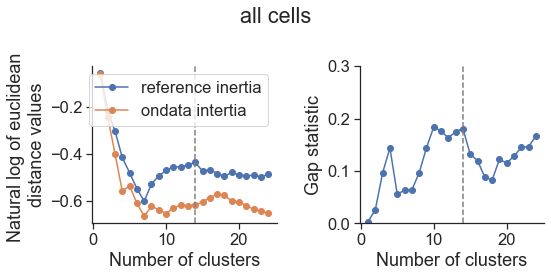

In [21]:
# plotting.plot_gap_statistic is not autoreloading
plotting.plot_gap_statistic(gap_df, cre_lines=['all'], n_clusters_cre=14, 
                            tag='with_cre_shuffle', save_dir=glm_path, folder='')

## Eigen gap

In [22]:
eigengap=processing.load_eigengap(glm_version, feature_matrix, cre_line='all', save_dir=glm_path, k_max=25)

loading eigengap values scores from C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache\GLM\eigengap_24_events_all_L2_optimize_by_session_kmax25all.pkl
done.


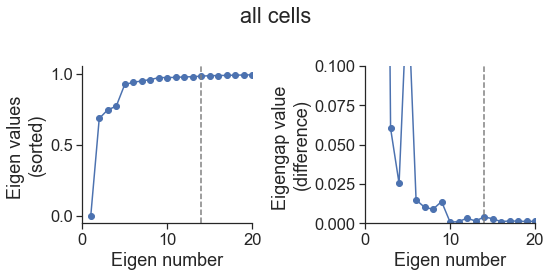

In [23]:
plotting.plot_eigengap_values(eigengap, cre_lines=['all'], n_clusters_cre={'all':14}, save_dir=glm_path, folder='')

## Silhouette Score

In [24]:
from sklearn.cluster import SpectralClustering

X=feature_matrix.values
n_clusters=np.arange(3, 25)
metric='euclidean'
n_boots=20
silhouette_filename= os.path.join(glm_path, 'silhouette_score_{}_{}_clusters_metric_{}_nboots_{}.pkl'.format(n_clusters[0], n_clusters[-1], metric, n_boots))
if os.path.exists(silhouette_filename):
    with open(silhouette_filename, 'rb') as f:
        silhouette_scores, silhouette_std = pickle.load(f)
        print('loaded file')
else:
    
    silhouette_scores, silhouette_std = processing.get_silhouette_scores(X=X, model=SpectralClustering(), n_clusters=n_clusters, metric=metric, n_boots=n_boots)
    processing.save_clustering_results([silhouette_scores, silhouette_std], silhouette_filename)

size of X = (3921, 12)
NaNs in the array = 0
n 3 clusters mean score = 0.3349845661323732
n 4 clusters mean score = 0.4069987218609019
n 5 clusters mean score = 0.4274779993301042
n 6 clusters mean score = 0.4232553452166844
n 7 clusters mean score = 0.4036032252117576
n 8 clusters mean score = 0.41210734840216234
n 9 clusters mean score = 0.41757344569273186
n 10 clusters mean score = 0.40408007163718784
n 11 clusters mean score = 0.40737194667134347
n 12 clusters mean score = 0.40857312895060327
n 13 clusters mean score = 0.41413449410737596
n 14 clusters mean score = 0.40538159743669866
n 15 clusters mean score = 0.3999612183944437
n 16 clusters mean score = 0.39949822564734827
n 17 clusters mean score = 0.3945530516079975
n 18 clusters mean score = 0.3990185551086973
n 19 clusters mean score = 0.3686756005952238
n 20 clusters mean score = 0.3683376291748047
n 21 clusters mean score = 0.3637180963233119
n 22 clusters mean score = 0.35928233958030453
n 23 clusters mean score = 0.3476

<AxesSubplot:title={'center':', '}, xlabel='Number of clusters', ylabel='Silhouette score'>

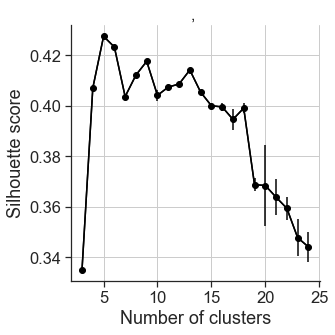

In [25]:

plotting.plot_silhouette_scores(silhouette_scores=silhouette_scores, n_clusters=n_clusters, silhouette_std=silhouette_std,
                             ax=None, model_output_type='')

## Coclustering matrix

In [26]:
from sklearn.cluster import SpectralClustering

In [27]:
# number of optimal clusters
n_clusters = 14

coclust_filename = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')

if os.path.exists(coclust_filename):
    coclustering_df = pd.read_hdf(coclust_filename, key='df')
    print('found and loaded cached coclustering matrix file...')
else:
    print('did not find cached coclustering matrix file, will make one...')
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_file = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')
    coclustering_df.to_hdf(coclust_filename, key='df', format='table')
    print('created and saved coclustering_matrix file.')

found and loaded cached coclustering matrix file...


In [28]:
# not clusters coclustering matrix
# sns.heatmap(coclustering_df)

## Hierarchical cluster id assignment

In [29]:
# run agglomerative clustering on co-clustering matrix to identify cluster labels
from sklearn.cluster import AgglomerativeClustering

In [30]:
cluster_meta_filename = os.path.join(glm_path, f'cluster_meta_{n_clusters}_clusters.h5')
if os.path.exists(cluster_meta_filename):
    cluster_meta = pd.read_hdf(cluster_meta_filename,key='df')
    print('found and loaded cached cluster_meta file...')
else:
    print('did not find cached cluster_meta file, will make one...')
    cluster_meta = processing.create_and_save_cluster_meta(coclustering_df, n_clusters, feature_matrix, cells_table_matched, cluster_meta_filename)
    

found and loaded cached cluster_meta file...


In [31]:
# plot coclustering matrix - need to hack it since it assumes cre lines
# THIS TAKES A LONG TIME (20+ min)
# coclustering_dict = {}
# coclustering_dict['all'] = coclustering_df
# cluster_meta_tmp = cluster_meta.copy()
# cluster_meta_tmp['cre_line'] = 'all'
# plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
#                                                                  save_dir=glm_path, folder='',
#                                                                  suffix='_' + str(n_clusters) + '_clusters', ax=None)

In [32]:
# plot within cluster correlations distribution
# plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=False, suffix='_'+str(n_clusters)+'_clusters',
#                                                save_dir=glm_path, folder='', ax=None)

## main cluster plots

### heatmaps

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


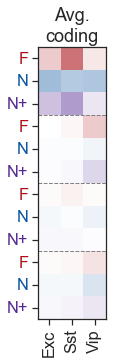

In [33]:
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, save_dir=glm_path, folder='')

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


<AxesSubplot:title={'center':'Cluster averages'}, xlabel='Cluster ID'>

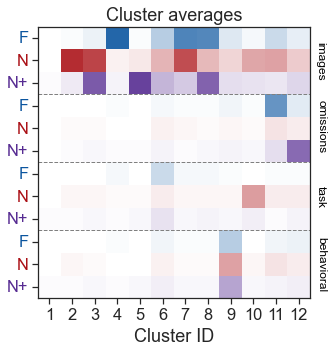

In [38]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=glm_path, folder='', ax=None)

<AxesSubplot:xlabel='cells'>

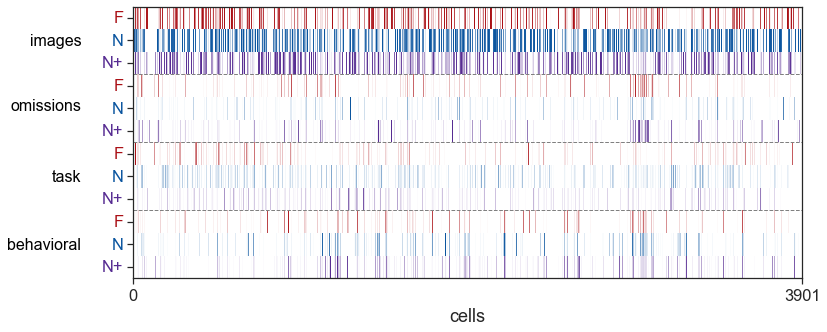

In [35]:
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plotting.plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, sort_by=None, session_colors=True,
                                    save_dir=None, folder='', ax=None)

<AxesSubplot:xlabel='Cluster ID'>

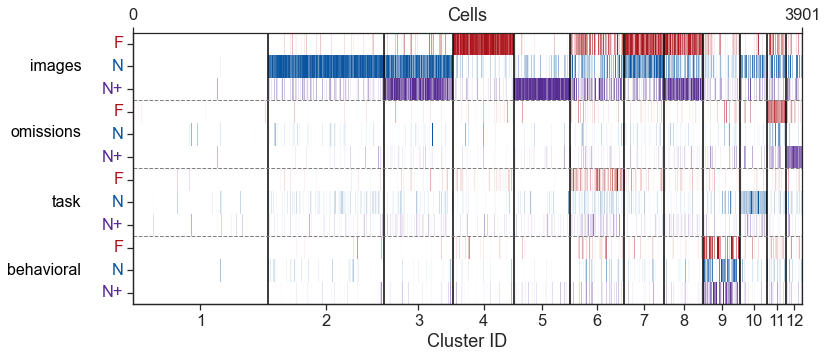

In [36]:
plotting.plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', session_colors=True,
                                    save_dir=glm_path, folder='', ax=None)

### supplemental figure 21, clusters by cre lines

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_meta_cre.cluster_id.values]


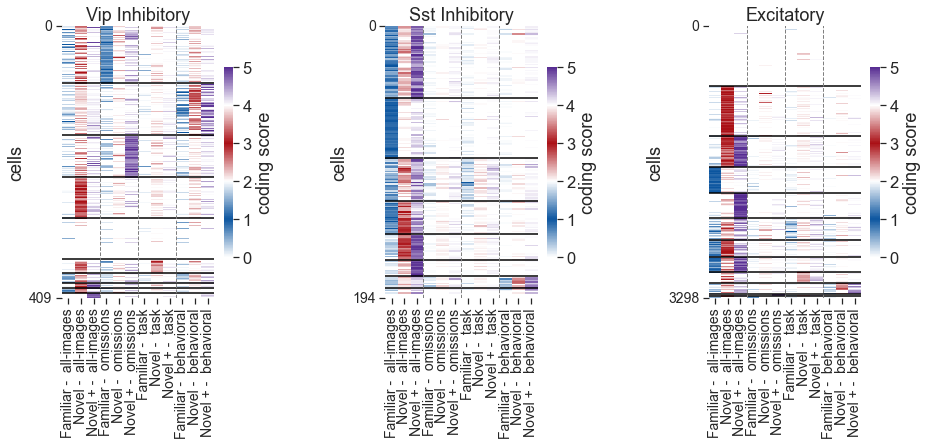

In [39]:
# plot feature matrix sorted by cluster ID
feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=True,
                                    cmap=remapped_cmap, vmax=vmax, save_dir=None, folder='')

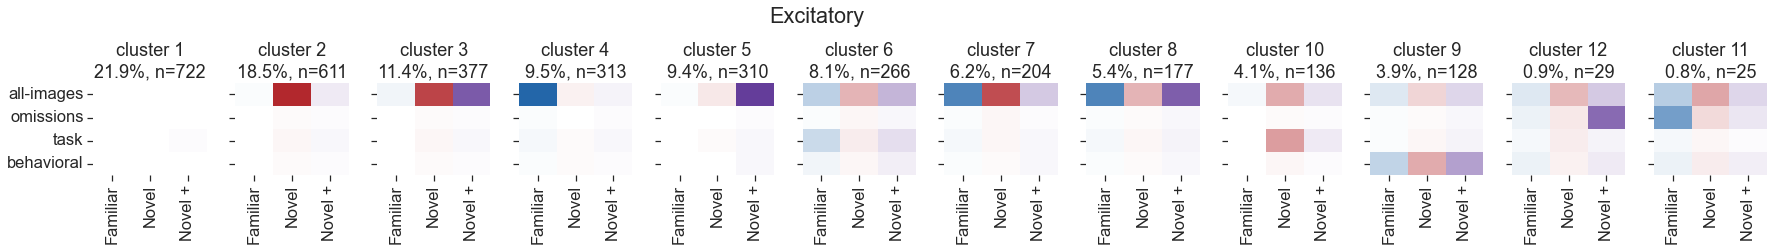

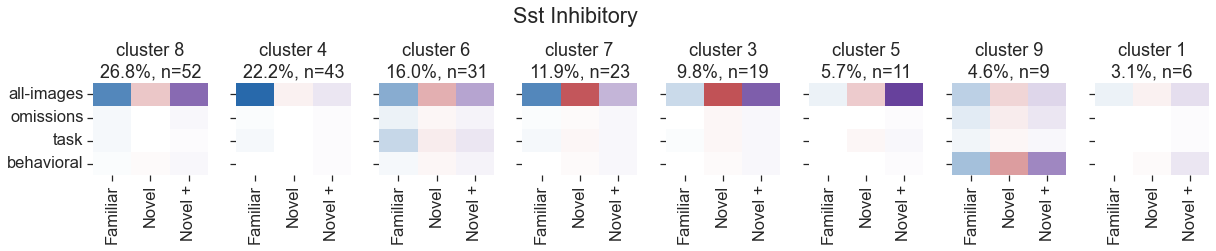

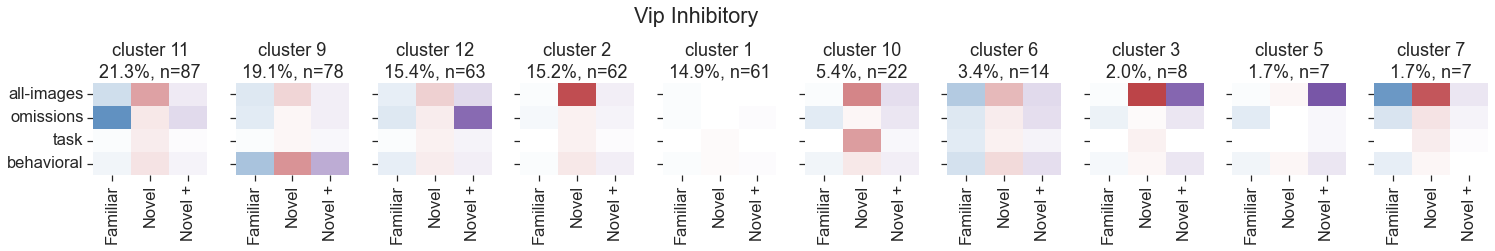

In [56]:
#Sizing is off a bit

for cre_line in cre_lines:
    cluster_meta_cre = cluster_meta[cluster_meta.cre_line==cre_line]
    clusters = cluster_meta_cre.value_counts('cluster_id').index.values
    plotting.plot_mean_cluster_heatmaps_remapped(feature_matrix, cluster_meta_cre, cre_line, clusters, save_dir=glm_path, folder='')

### fraction cells per cluster per cre

12 12
8 12
10 12


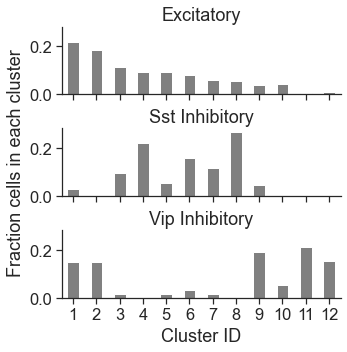

In [42]:
plotting.plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', 
                                                    save_dir=glm_path, folder='')

In [43]:
cell_counts = cluster_meta.groupby(['cell_type']).count().rename(columns={'cre_line':'n_cells'})[['n_cells']]
cell_counts.head()

,n_cells
cell_type,
Excitatory,3298
Sst Inhibitory,194
Vip Inhibitory,409


In [44]:
cell_counts = cluster_meta.reset_index().drop_duplicates(subset='cell_specimen_id').copy()
cell_counts = cell_counts.groupby(['cell_type']).count()
cell_counts.head()

,cell_specimen_id,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,...,layer,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_type,,,,,,,,,,,,,,,,,,,,,
Excitatory,3298,3298,3298,3298,3298,3298,3298,3298,3298,3298,...,3298,3298,3298,3298,3298,3298,3298,3298,3298,3298
Sst Inhibitory,194,194,194,194,194,194,194,194,194,194,...,194,194,194,194,194,194,194,194,194,194
Vip Inhibitory,409,409,409,409,409,409,409,409,409,409,...,409,409,409,409,409,409,409,409,409,409


# Cluster description

## Distribution of animals and rigs across clusters

In [45]:
cluster_df=cluster_meta.copy()

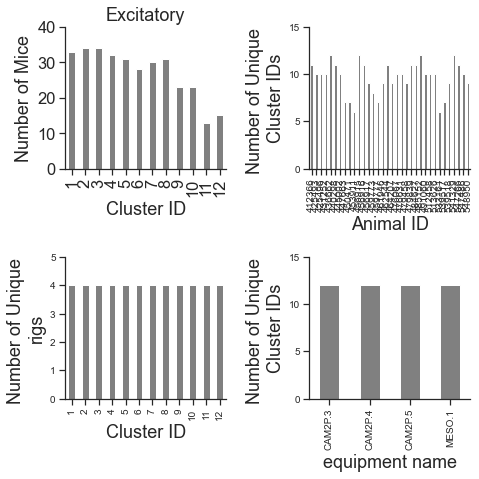

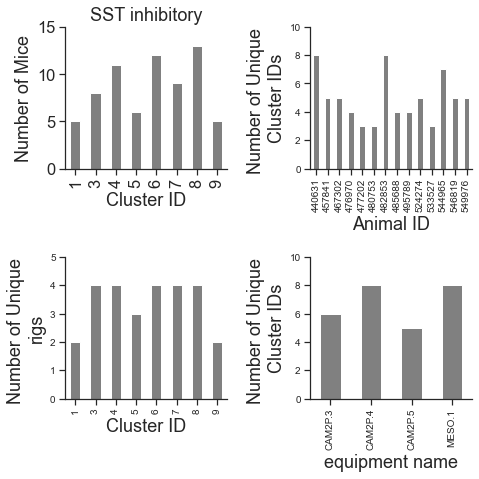

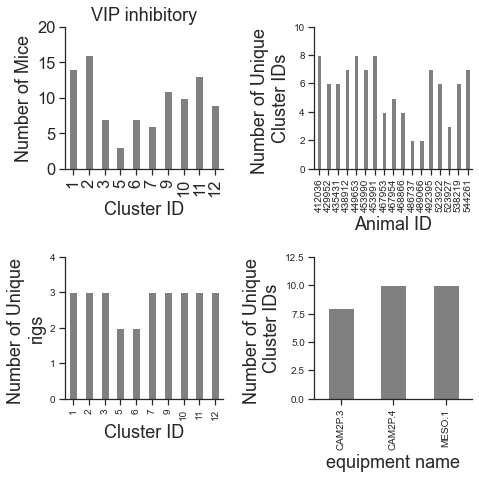

In [46]:
plotting.plot_cluster_info(cre_lines, cluster_df, save_dir=glm_path)

## UMAP

In [47]:
## 20 cells that were matched were dropped 
csids = cluster_meta.index.values
cluster_feature_matrix = feature_matrix.loc[csids]

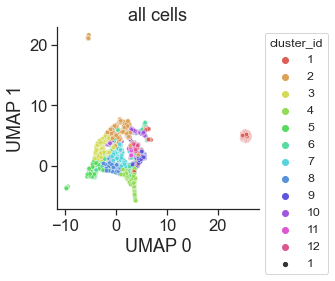

In [48]:
plotting.plot_umap_for_clusters(cluster_meta, cluster_feature_matrix, label_col='cluster_id', cre_lines = ['all'], save_dir=glm_path, folder='')

## Within cluster correlation

In [49]:
cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta,
                                                               use_spearmanr=True)

adding within cluster correlation to cluster_meta


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<AxesSubplot:title={'center':'correlation'}, xlabel='cluster #', ylabel='correlation'>

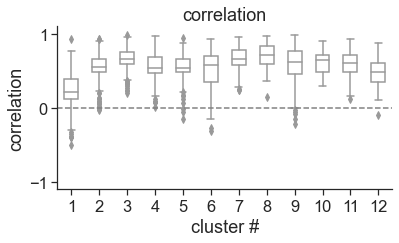

In [53]:
# plot within cluster correlations distribution
### DOUBLE CHECK
n_clusters=14
plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=True, suffix='_'+str(n_clusters)+'_clusters',
                                                save_dir='', folder='', ax=None)

#### results pivoted

In [51]:
results_pivoted = across_results[[key for key in across_results.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
results_pivoted['experience_level'] = results_pivoted['experience_level'].replace({'Novel 1': 'Novel', 'Novel >1': 'Novel +'})

### combine cluster meta data and glm output to obtain coding scores metrics


In [52]:
import warnings
warnings.filterwarnings('ignore')
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

AttributeError: module 'visual_behavior.dimensionality_reduction.clustering.processing' has no attribute 'get_cell_metrics'

In [ ]:
cluster_meta.reset_index()

## Mean image, change, and omissions

### load multiresponse dataframes

In [57]:
import visual_behavior.data_access.loading as loading

#### load image, change, omissions multi experiment dataframes

In [69]:

data_type = 'filtered_events'
interpolate = True
output_sampling_rate = 30

inclusion_criteria = 'platform_experiment_table'

# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']

suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria
image_mdf_filename=os.path.join(base_path, f'image_df_{suffix}.h5')

if os.path.exists(image_mdf_filename):
    image_mdf = pd.read_hdf(image_mdf_filename, key='df')
else:
    image_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

    image_mdf = image_mdf[image_mdf.is_change==False]
    image_mdf.to_hdf(image_mdf_filename, key='df')



loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_filtered_events_all_is_change_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_filtered_events_all_is_change_platform_experiment_table.pkl
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


In [70]:

change_mdf_filename=os.path.join(base_path, f'change_df_{suffix}.h5')
if os.path.exists(change_mdf_filename):
    change_mdf = pd.read_hdf(change_mdf_filename, key='df')
else:
    image_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

    change_mdf = image_mdf[image_mdf.is_change==True]
    change_mdf.to_hdf(change_mdf_filename, key='df')
    

loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_filtered_events_all_is_change_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_filtered_events_all_is_change_platform_experiment_table.pkl
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


In [71]:
 
# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']
omission_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_mdf_filename=os.path.join(base_path, f'omission_df_{omission_suffix}.h5')
if os.path.exists(omission_mdf_filename):
    omission_mdf = pd.read_hdf(omission_mdf_filename, key='df')
    
else:
    
    omission_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

    omission_mdf = omission_mdf[omission_mdf.omitted==True]
    omission_mdf.to_hdf(omission_mdf_filename, key='df')
    
    

loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_filtered_events_all_omitted_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_filtered_events_all_omitted_platform_experiment_table.pkl
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


### image

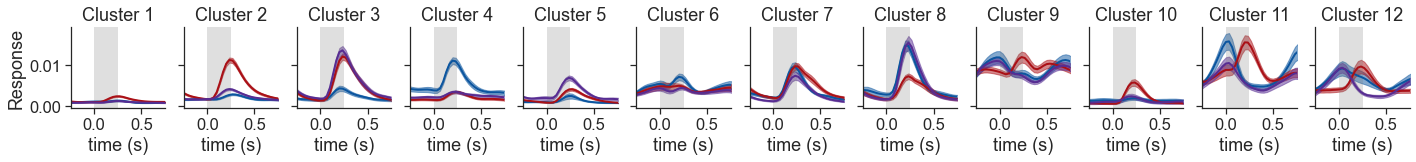

In [72]:
folder = 'figure_4'
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, event_type, axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=glm_path, folder=folder, suffix='_sharey', ax=None);

### change

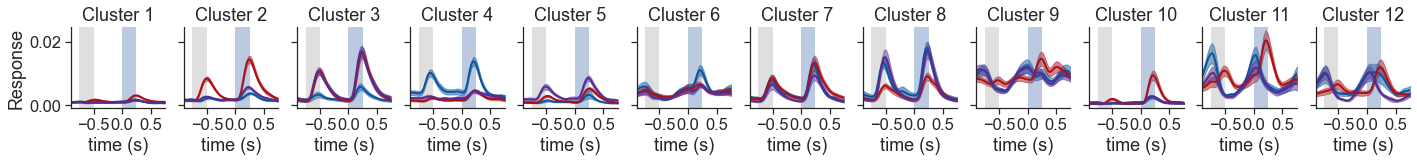

In [73]:
folder = 'suppl_figure_4'
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

xlim_seconds = [-0.9, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=glm_path, folder=folder, suffix='_sharey', ax=None);

### omissions

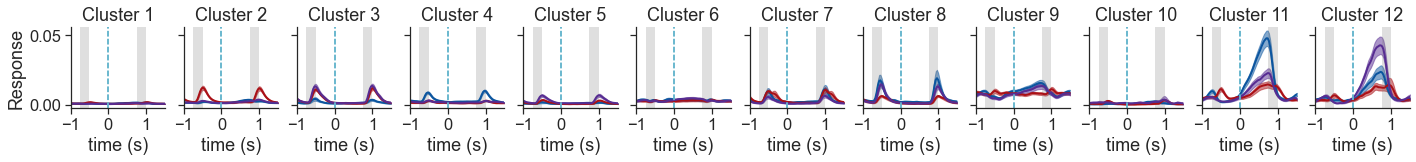

In [74]:
folder = 'suppl_figure_4'
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=1, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=glm_path, folder=folder, suffix='_sharey', ax=None);

## Area and depth analysis

### panel g

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table = n_cells_table.reset_index()

xorder = np.sort(n_cells_table.cluster_id.unique())

hue = 'layer'
hue_order = np.sort(n_cells_table[hue].unique())[::-1]

metric = 'fraction_cells_location'
ylabel = 'Fraction cells'
significance_col = 'bh_significant'



In [ ]:
plotting.plot_cluster_depth_distributi_by_ncre_lines(n_cells_table, metric, xorder, hue, hue_order, significance_col, save_dir=glm_path, folder='')

### Supplemental 

### by layers (upper vs lower)

In [ ]:
folder = 'figure_4'
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=glm_path, folder=folder);

### by targeted structure (V1 vs LM)

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=True, 
                                                             ax=None, save_dir=glm_path, folder='');

### targeted structure and layer - number of cells 

In [ ]:
folder = 'figure_4'
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col, sharex=False,
                                                             ax=None, save_dir=glm_path, folder='');

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=False, 
                                                             ax=None, save_dir=glm_path, folder='');

### binned depth 

In [ ]:
location = 'binned_depth'
n_cells_table= processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=None,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col, sharex=False, 
                                                             ax=None, save_dir=glm_path, folder='');

## Experience modulation across clusters

### boxplot of experience modulation by cluster id and cell class panel h

In [ ]:
plotting.plot_experience_modulation(coding_score_metrics, metric='experience_modulation', save_dir=glm_path, folder='')

### scatterplot of experience modulation by cortical depth

In [ ]:
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)


In [ ]:

x = 'exp_mod_direction' # novel-familiar / sum
y = 'layer_index' # upper-lower / sum
hue = 'cell_type'

if 'cell_type' not in cluster_metrics.columns:
    cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=glm_path, folder='')

### scatterplot

# Model free metrics

In [ ]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

In [ ]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\all_cre_clustering_113023'
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=save_dir)

In [ ]:
response_metrics = metrics.copy()

In [ ]:
response_metrics.keys()

## image selectivity

In [ ]:
plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric = 'lifetime_sparseness_images', cre_lines=cre_lines, n_clusters=12, experience_levels=experience_levels, experience_level_colors=experience_level_colors)

## run modulation

In [ ]:
plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric = 'running_modulation_all_images', cre_lines=cre_lines, 
                                              n_clusters=12, experience_levels=experience_levels, experience_level_colors=experience_level_colors)

## fano factor

In [ ]:
plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric = 'fano_factor_pref_image', cre_lines=cre_lines, 
                                              n_clusters=12, experience_levels=experience_levels, experience_level_colors=experience_level_colors)

## change modulation

In [ ]:
plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric = 'change_modulation_index', cre_lines=cre_lines, 
                                              n_clusters=12, experience_levels=experience_levels, experience_level_colors=experience_level_colors)

## stats

In [ ]:
from scipy.stats import f_oneway

# Group data by 'cluster_id' and collect 'running_modulation' values for each group
response_metrics_clean = response_metrics.dropna(subset=['running_modulation_all_images'])

groups = [data for _, data in response_metrics_clean.groupby('cluster_id')['running_modulation_all_images']]

# Perform one-way ANOVA test
f_statistic, p_value = f_oneway(*groups)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the means of the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the groups.")

In [ ]:
response_metrics.groupby('cluster_id')['running_modulation_all_images'].mean()

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# Create a MultiComparison object
multi_comp = MultiComparison(response_metrics_clean['running_modulation_all_images'], response_metrics_clean['cluster_id'])

# Perform Tukey's HSD test
tukey_results = multi_comp.tukeyhsd()

# Print the summary of the test
print(tukey_results.summary())

In [ ]:


# Plot the results in a grid
tukey_results.plot_simultaneous(ylabel='Cluster ID', xlabel='Difference in means')

plt.show()